라이브러리

In [6]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'Test230530-01_LSTMJaponicaTank2'

In [7]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('날짜')
    plt.ylabel('DO')
    plt.title('시계열')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    #result = model.evaluate(X_test_shape, y_test)
    #print("MSE // MAE // R-squared ", result)
    

데이터셋 설정

In [9]:
japonica_training_data = pd.read_csv("data2.csv")
japonica_training_data

,mea_dt,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
0,2021-07-16 00:00,1,8.3,30.4,5.63,156.0,15.4,0.0,3.9,0.0,0.0
1,2021-07-16 00:01,1,8.4,30.4,5.63,155.7,15.4,0.0,3.9,0.0,0.0
2,2021-07-16 00:02,1,8.4,30.4,5.63,155.8,15.4,0.0,4.0,0.0,0.0
3,2021-07-16 00:03,1,8.4,30.4,5.63,156.0,15.4,0.0,4.0,0.0,0.0
4,2021-07-16 00:04,1,8.4,30.4,5.62,156.3,15.4,0.0,3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
205915,2022-01-05 23:55,1,12.0,28.7,5.19,222.8,31.2,11.4,4.0,0.0,0.0
205916,2022-01-05 23:56,1,12.0,28.7,5.19,222.8,31.1,11.2,4.0,0.0,0.0
205917,2022-01-05 23:57,1,12.0,28.7,5.18,222.9,31.1,11.1,4.0,0.0,0.0
205918,2022-01-05 23:58,1,12.1,28.7,5.18,222.8,31.1,11.4,4.1,0.0,0.0


In [12]:
japonica_training_data['mea_dt'] = pd.to_datetime(japonica_training_data['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_training_data.set_index('mea_dt', inplace=True)
japonica_training_data = japonica_training_data[['tank_id','do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_data

,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,,
2021-07-16 00:00:00,1,8.3,30.4,5.63,156.0,15.4,0.0,3.9,0.0,0.0
2021-07-16 00:01:00,1,8.4,30.4,5.63,155.7,15.4,0.0,3.9,0.0,0.0
2021-07-16 00:02:00,1,8.4,30.4,5.63,155.8,15.4,0.0,4.0,0.0,0.0
2021-07-16 00:03:00,1,8.4,30.4,5.63,156.0,15.4,0.0,4.0,0.0,0.0
2021-07-16 00:04:00,1,8.4,30.4,5.62,156.3,15.4,0.0,3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-01-05 23:55:00,1,12.0,28.7,5.19,222.8,31.2,11.4,4.0,0.0,0.0
2022-01-05 23:56:00,1,12.0,28.7,5.19,222.8,31.1,11.2,4.0,0.0,0.0
2022-01-05 23:57:00,1,12.0,28.7,5.18,222.9,31.1,11.1,4.0,0.0,0.0


In [23]:
japonica_training_features_X = japonica_training_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]
# japonica_validation_features_X = japonica_validation_features_tank[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
# japonica_validation_features_y = japonica_validation_features_tank[['do_mg']]

In [24]:
japonica_training_features_X_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
    
    # for j in range(0, 180):
    #     nested_chunk = []
    #     for col in japonica_training_features_X.columns:
    #         values = japonica_training_features_X[col].values
    #         nested_values = values[i+j:i+j+10]
    #         nested_chunk.append(nested_values)
    #     chunk.append(nested_chunk)
    # japonica_training_features_X_chunks.append(chunk)

japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

In [25]:
japonica_training_features_X_chunks

array([[[ 8.3 , 30.4 ,  5.63, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
        ...,
        [ 8.6 , 30.4 ,  5.33, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.33, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ]],

       [[ 8.4 , 30.4 ,  5.63, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
        ...,
        [ 8.6 , 30.4 ,  5.33, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ]],

       [[ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.62, ...,  3.9 ,  0.  ,  0.  ],
        ...,
        [ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.

In [26]:
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
    # for j in range(0, 180):
    #     nested_chunk = []
    #     for col in japonica_training_features_X.columns:
    #         values = japonica_training_features_X[col].values
    #         nested_values = values[i+j:i+j+10]
    #         nested_chunk.append(nested_values)
    #     chunk.append(nested_chunk)
    # japonica_training_features_X_chunks.append(chunk)

japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)

In [27]:
japonica_training_features_y_chunks

array([[[ 8.3],
        [ 8.4],
        [ 8.4],
        ...,
        [ 8.6],
        [ 8.6],
        [ 8.6]],

       [[ 8.4],
        [ 8.4],
        [ 8.4],
        ...,
        [ 8.6],
        [ 8.6],
        [ 8.6]],

       [[ 8.4],
        [ 8.4],
        [ 8.4],
        ...,
        [ 8.6],
        [ 8.6],
        [ 8.7]],

       ...,

       [[ 9.6],
        [ 9.6],
        [ 9.6],
        ...,
        [12. ],
        [12. ],
        [12. ]],

       [[ 9.6],
        [ 9.6],
        [ 9.5],
        ...,
        [12. ],
        [12. ],
        [12.1]],

       [[ 9.6],
        [ 9.5],
        [ 9.5],
        ...,
        [12. ],
        [12.1],
        [12.1]]])

In [28]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# # shape확인
# nCar = japonica_validation_features_X_reshape.shape[0] # 데이터 개수
# nVar = japonica_validation_features_X_reshape.shape[2] # 변수 개수
# print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# nCar = japonica_validation_features_y.shape[0] # 데이터 개수
# nVar = japonica_validation_features_y.shape[1] # 변수 개수
# print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 205741 nVar: 9
nCar: 205741 nVar: 180


In [29]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

In [30]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )


nCar: 205561 nVar: 9
nCar: 205561 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [31]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(180, 9), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(180, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-06-16 02:51:15.426647: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 02:51:15.941448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 180, 128)          70656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 180, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 180)               5940      
Total params: 138,420
Trainable params: 138,420
Non-trainable params: 0
_________________________________________________________________


2023-06-16 02:51:19.535716: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-06-16 02:51:24.213141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-06-16 02:51:25.172111: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6424/6424 [==============================] - 290s 44ms/step - loss: 2.1218 - mae: 0.9040 - r_squared: 0.2613 - val_loss: 0.3197 - val_mae: 0.3669 - val_r_squared: -2.0565
Epoch 2/200
6424/6424 [==============================] - 278s 43ms/step - loss: 0.3306 - mae: 0.3806 - r_squared: 0.8833 - val_loss: 0.3310 - val_mae: 0.3790 - val_r_squared: -2.3722
Epoch 3/200
6424/6424 [==============================] - 280s 44ms/step - loss: 0.3202 - mae: 0.3763 - r_squared: 0.8868 - val_loss: 0.3011 - val_mae: 0.3654 - val_r_squared: -2.4304
Epoch 4/200
6424/6424 [==============================] - 280s 44ms/step - loss: 0.3051 - mae: 0.3661 - r_squared: 0.8920 - val_loss: 0.3061 - val_mae: 0.3762 - val_r_squared: -2.6354
Epoch 5/200
6424/6424 [==============================] - 279s 43ms/step - loss: 0.2948 - mae: 0.3620 - r_squared: 0.8957 - val_loss: 0.2800 - val_mae: 0.3464 - val_r_squared: -1.9129
Epoch 6/200
6424/6424 [==============================] - 279s 43ms/step - loss: 0.2888 - mae: 0.3

Epoch 88/200
6424/6424 [==============================] - 278s 43ms/step - loss: 0.1099 - mae: 0.2345 - r_squared: 0.9608 - val_loss: 0.1099 - val_mae: 0.2345 - val_r_squared: -0.5922

Epoch 00088: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 89/200
6424/6424 [==============================] - 277s 43ms/step - loss: 0.1099 - mae: 0.2345 - r_squared: 0.9608 - val_loss: 0.1099 - val_mae: 0.2345 - val_r_squared: -0.5922
Epoch 90/200
6424/6424 [==============================] - 279s 43ms/step - loss: 0.1099 - mae: 0.2345 - r_squared: 0.9608 - val_loss: 0.1099 - val_mae: 0.2345 - val_r_squared: -0.5922
Epoch 91/200
6424/6424 [==============================] - 278s 43ms/step - loss: 0.1099 - mae: 0.2345 - r_squared: 0.9608 - val_loss: 0.1099 - val_mae: 0.2345 - val_r_squared: -0.5922

Epoch 00091: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 92/200
6424/6424 [==============================] - 278s 43ms/step - loss: 0.1099 - mae: 0.2345 

모델 평가

In [33]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 0.04123846 -0.08717101  0.03503811 ...  0.03751392  0.04791444
   0.3678781 ]
 [ 0.16532552  0.0792144   0.02432945 ...  0.05856925  0.00090234
  -0.03394513]
 [-0.00622267 -0.03351446  0.06223287 ...  0.01745683 -0.18967046
   0.20858984]
 ...
 [ 0.08247125 -0.08036777  0.06337326 ... -0.02996756 -0.13013864
   0.15816759]
 [-0.04194462 -0.05256636  0.00120261 ... -0.04911606 -0.07538651
  -0.04824786]
 [-0.07896454 -0.13964073 -0.07037744 ... -0.00857883  0.09665971
   0.07223787]]


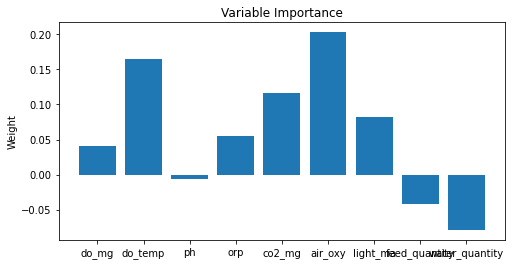

In [34]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(9), weights[:, 0])
ax.set_xticks(range(9))
ax.set_xticklabels(['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [35]:
X_pred = model.predict(japonica_training_features_X_reshape)
X_pred = np.array(X_pred).flatten()

X_pred = pd.DataFrame(X_pred)

start = pd.Timestamp(japonica_training_features_X.index[0]) + pd.Timedelta(hours=3)

# 시계열 인덱스 생성
index = pd.date_range(start, periods=len(X_pred), freq='1min')

# 데이터프레임의 인덱스를 시계열 인덱스로 변경
X_pred.index = index

X_pred

NameError: name 'japonica_training_features_X_reshape' is not defined

In [36]:
japonica_training_features_y = japonica_training_features_y.reset_index()
japonica_training_features_y['mea_dt'] = pd.to_datetime(japonica_training_features_y['mea_dt'], format='mixed', errors='raise')
japonica_training_features_y.set_index('mea_dt', inplace=True)
japonica_training_features_y

,do_mg
mea_dt,
2021-07-16 00:00:00,8.3
2021-07-16 00:01:00,8.4
2021-07-16 00:02:00,8.4
2021-07-16 00:03:00,8.4
2021-07-16 00:04:00,8.4
...,...
2022-01-05 23:55:00,12.0
2022-01-05 23:56:00,12.0
2022-01-05 23:57:00,12.0


In [37]:
japonica_training_features_y.index

DatetimeIndex(['2021-07-16 00:00:00', '2021-07-16 00:01:00',
               '2021-07-16 00:02:00', '2021-07-16 00:03:00',
               '2021-07-16 00:04:00', '2021-07-16 00:05:00',
               '2021-07-16 00:06:00', '2021-07-16 00:07:00',
               '2021-07-16 00:08:00', '2021-07-16 00:09:00',
               ...
               '2022-01-05 23:50:00', '2022-01-05 23:51:00',
               '2022-01-05 23:52:00', '2022-01-05 23:53:00',
               '2022-01-05 23:54:00', '2022-01-05 23:55:00',
               '2022-01-05 23:56:00', '2022-01-05 23:57:00',
               '2022-01-05 23:58:00', '2022-01-05 23:59:00'],
              dtype='datetime64[ns]', name='mea_dt', length=205920, freq=None)

NameError: name 'X_pred' is not defined

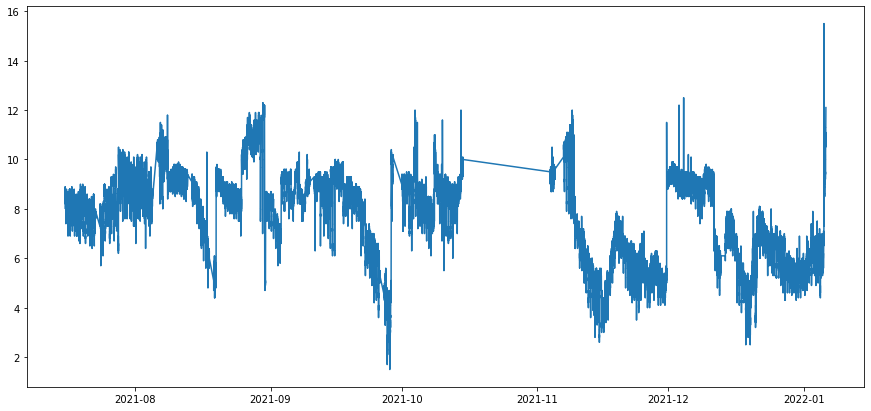

In [38]:
# 그래프 생성
plt.figure(figsize=(15, 7))
plt.plot(japonica_training_features_y.index, japonica_training_features_y, label='actual')  # x축에 년월일, y축에 값
plt.plot(X_pred.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
plt.xlabel('날짜')
plt.ylabel('DO')
plt.title('시계열')
plt.legend(['y_test','X_pred'])
plt.show()

In [41]:
japonica_training_data

,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,,
2021-07-16 00:00:00,1,8.3,30.4,5.63,156.0,15.4,0.0,3.9,0.0,0.0
2021-07-16 00:01:00,1,8.4,30.4,5.63,155.7,15.4,0.0,3.9,0.0,0.0
2021-07-16 00:02:00,1,8.4,30.4,5.63,155.8,15.4,0.0,4.0,0.0,0.0
2021-07-16 00:03:00,1,8.4,30.4,5.63,156.0,15.4,0.0,4.0,0.0,0.0
2021-07-16 00:04:00,1,8.4,30.4,5.62,156.3,15.4,0.0,3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-01-05 23:55:00,1,12.0,28.7,5.19,222.8,31.2,11.4,4.0,0.0,0.0
2022-01-05 23:56:00,1,12.0,28.7,5.19,222.8,31.1,11.2,4.0,0.0,0.0
2022-01-05 23:57:00,1,12.0,28.7,5.18,222.9,31.1,11.1,4.0,0.0,0.0


In [42]:
# 하루 동안의 데이터 추출
one_day_data = japonica_training_data.loc['2021-07-17 06:00':'2021-07-17 08:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_training_data.loc['2021-07-17 09:00':'2021-07-17 12:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1 nVar: 9
nCar: 240 nVar: 1


180


ValueError: x and y must have same first dimension, but have shapes (240,) and (180,)

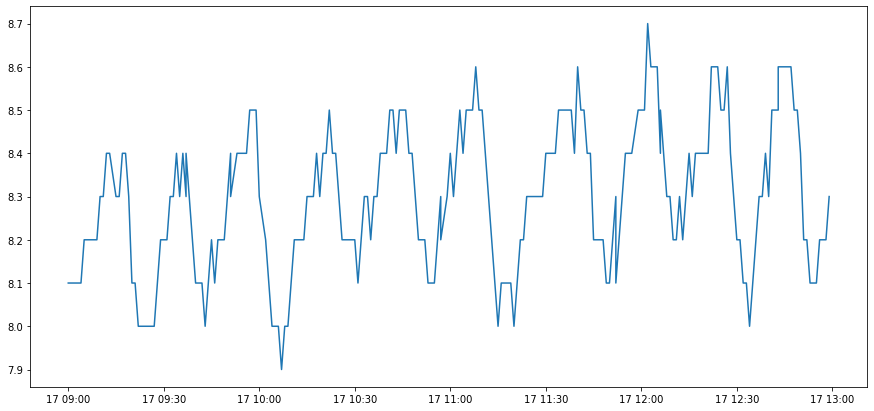

In [40]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)

In [ ]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-07-16 00:00:00':'2021-07-16 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)

In [ ]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-08-28 00:00:00':'2021-08-28 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)